<a href="https://colab.research.google.com/github/anish-mulay07/Reinforcement-Learning/blob/main/DDPG_Pendulumv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import gym
from collections import deque
import random

# Ornstein-Ulhenbeck Process
# Taken from #https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)


# https://github.com/openai/gym/blob/master/gym/core.py
class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """

    def action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b



class Memory:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)

    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)

        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)

DDPG uses four neural networks: a Q network, a deterministic policy network, a

1.   List item
2.   List item

target Q network, and a target policy network.



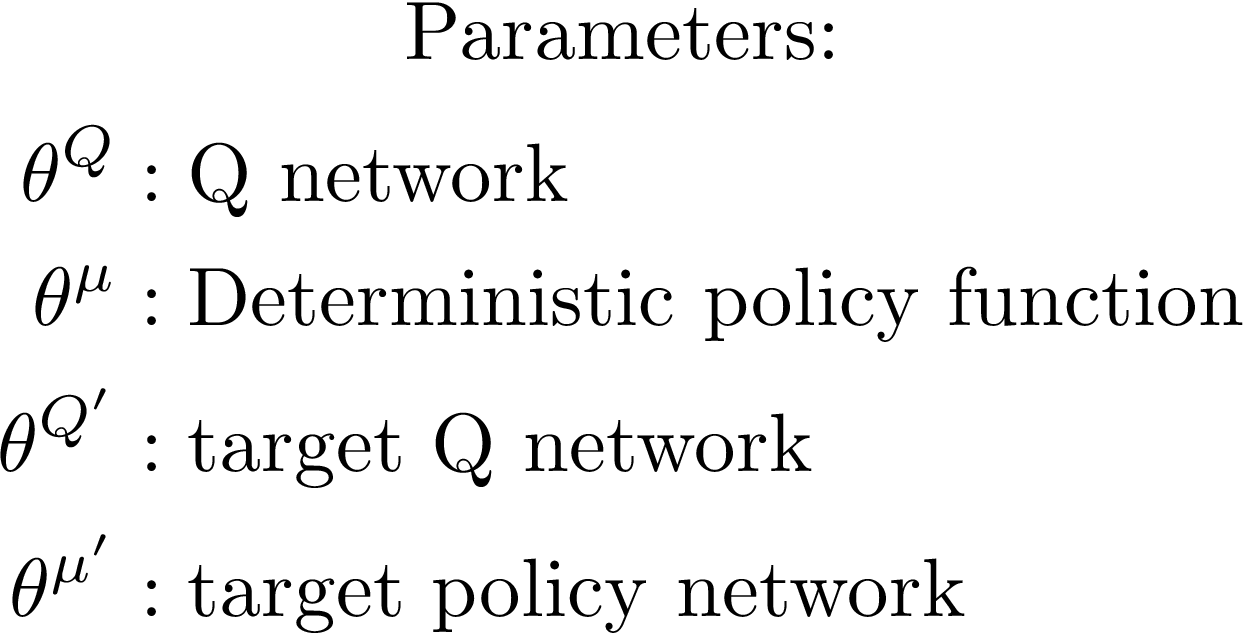



The Q network and policy network is very much like simple Advantage Actor-Critic, but in DDPG, the Actor directly maps states to actions (the output of the network directly the output) instead of outputting the probability distribution across a discrete action space.

The target networks are time-delayed copies of their original networks that slowly track the learned networks. Using these target value networks greatly improve stability in learning.

Let's create these networks.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd
from torch.autograd import Variable

class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state, action):
        """
        Params state and actions are torch tensors
        """
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 3e-4):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state):
        """
        Param state is a torch tensor
        """
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))

        return x

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now, let's create the DDPG agent. The agent class has two main functions: "get_action" and "update":



*   **get_action()**: This function runs a forward pass through the actor network to select a determinisitic action. In the DDPG paper, the authors use Ornstein-Uhlenbeck Process to add noise to the action output (Uhlenbeck & Ornstein, 1930), thereby resulting in exploration in the environment. Class OUNoise (in cell 1) implements this.


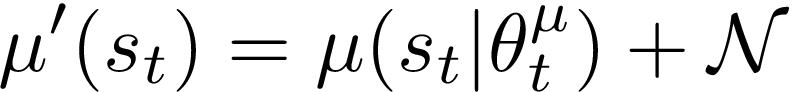



*   **update()**: This function is used for updating the actor and critic networks, and forms the core of the DDPG algorithm. The replay buffer is first sampled to get a batch of experiences of the form **<states, actions, rewards, next_states>**.

The value network is updated similarly as is done in Q-learning. The updated Q value is obtained by the Bellman equation. However, in DDPG, the next-state Q values are calculated with the target value network and target policy network. Then, we minimize the mean-squared loss between the updated Q value and the original Q value:

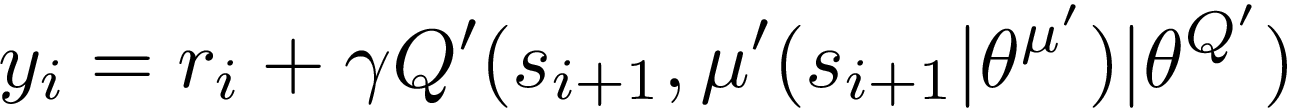

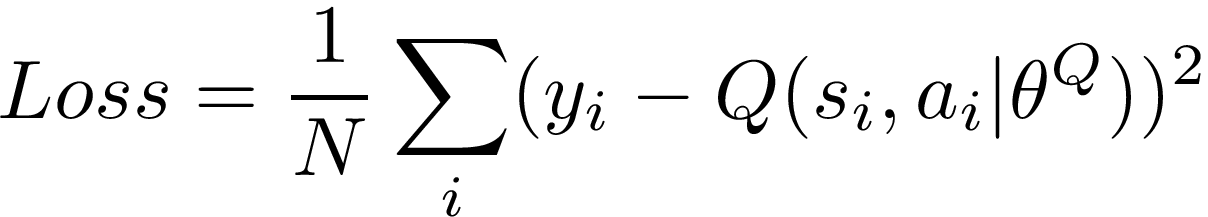

For the policy function, our objective is to maximize the expected return. To calculate the policy loss, we take the derivative of the objective function with respect to the policy parameter. Keep in mind that the actor (policy) function is differentiable, so we have to apply the chain rule.

But since we are updating the policy in an off-policy way with batches of experience, we take the mean of the sum of gradients calculated from the mini-batch:

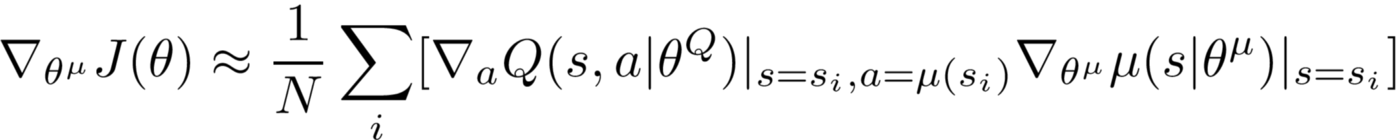

We make a copy of the target network parameters and have them slowly track those of the learned networks via “soft updates,” as illustrated below:

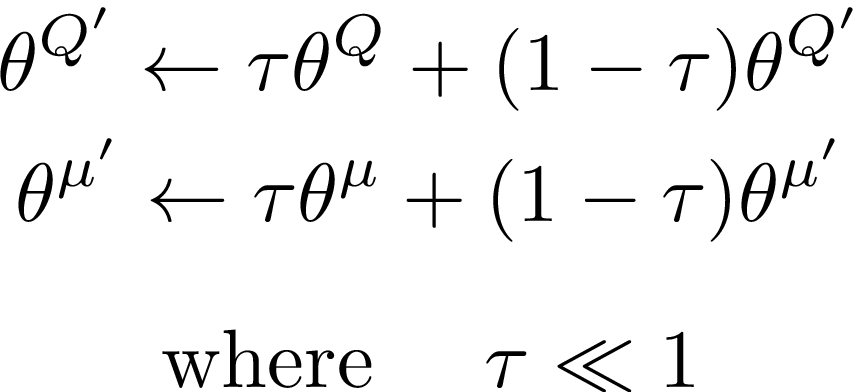






In [ ]:
import torch
import torch.autograd
import torch.optim as optim
import torch.nn as nn
# from model import *
# from utils import *

class DDPGagent:
    def __init__(self, env, hidden_size=256, actor_learning_rate=1e-4, critic_learning_rate=1e-3, gamma=0.99, tau=1e-2, max_memory_size=50000):
        # Params
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.shape[0]
        self.gamma = gamma
        self.tau = tau

        # Networks
        self.actor = Actor(self.num_states, hidden_size, self.num_actions)
        self.actor_target = Actor(self.num_states, hidden_size, self.num_actions)
        self.critic = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)
        self.critic_target = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)
            target_param.requires_grad = False

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
            target_param.requires_grad = False

        # Training
        self.memory = Memory(max_memory_size)
        self.critic_criterion  = nn.MSELoss()
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)

    def get_action(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        action = self.actor.forward(state)
        action = action.detach().numpy()[0,0]
        return action

    def update(self, batch_size):
        states, actions, rewards, next_states, _ = self.memory.sample(batch_size)
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)

        # Implement critic loss and update critic
        predicted_q_values = self.critic.forward(states, actions)
        target_next_actions = self.actor_target.forward(next_states)
        target_q_values_next = self.critic_target.forward(next_states, target_next_actions)
        target_q_values = rewards + self.gamma * target_q_values_next
        critic_loss = self.critic_criterion.forward(predicted_q_values, target_q_values)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()



        # Implement actor loss and update actor
        actions_pred = self.actor.forward(states)
        actor_loss = -self.critic.forward(states, actions_pred).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()


        # update target networks
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau*param.data + (1-self.tau)*target_param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau*param.data + (1-self.tau)*target_param.data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


*Putting* it all together: DDPG in action.

The main function below runs 50 episodes of DDPG on the "Pendulum-v1" environment of OpenAI gym. This is the inverted pendulum swingup problem, a classic problem in the control literature. In this version of the problem, the pendulum starts in a random position, and the goal is to swing it up so it stays upright.

Each episode is for a maximum of 500 timesteps. At each step, the agent chooses an action, updates its parameters according to the DDPG algorithm and moves to the next state, repeating this process till the end of the episode.

The DDPG algorithm is as follows:

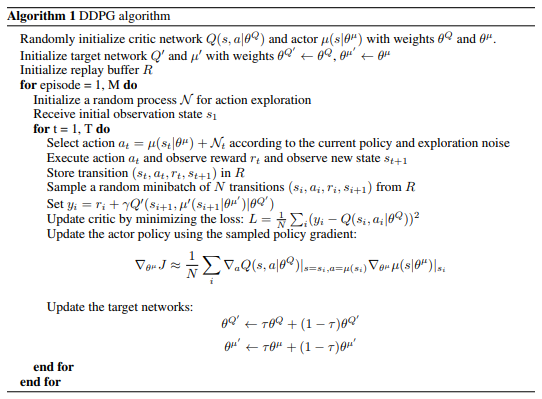

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
<ipython-input-3-239a5eeb5c01>:44: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarra

episode: 0, reward: -1166.25, average _reward: nan 
episode: 1, reward: -1542.32, average _reward: -1166.2509146802036 
episode: 2, reward: -1677.82, average _reward: -1354.2855673347626 
episode: 3, reward: -1568.09, average _reward: -1462.1317257365254 
episode: 4, reward: -1286.75, average _reward: -1488.6217625372017 
episode: 5, reward: -870.13, average _reward: -1448.2480338082473 
episode: 6, reward: -1015.14, average _reward: -1351.894631512874 
episode: 7, reward: -947.83, average _reward: -1303.7868509486618 
episode: 8, reward: -578.35, average _reward: -1259.292408992281 
episode: 9, reward: -629.14, average _reward: -1183.6326436987622 
episode: 10, reward: -543.82, average _reward: -1128.1835325734344 
episode: 11, reward: -521.44, average _reward: -1065.9409088761865 
episode: 12, reward: -522.59, average _reward: -963.8530713904092 
episode: 13, reward: -385.46, average _reward: -848.3295251478688 
episode: 14, reward: -131.14, average _reward: -730.0665330779369 
episo

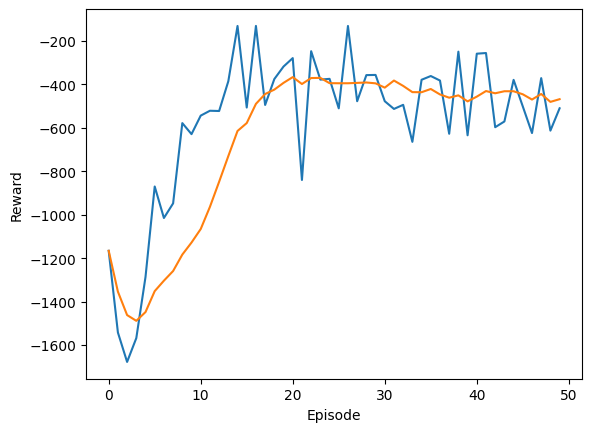

In [ ]:
import sys
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

env = NormalizedEnv(gym.make("Pendulum-v1"))

agent = DDPGagent(env)
noise = OUNoise(env.action_space)
batch_size = 128
rewards = []
avg_rewards = []

for episode in range(50):
    state = env.reset()
    noise.reset()
    episode_reward = 0

    for step in range(500):
        action = agent.get_action(state)
        #Add noise to action

        action = noise.get_action(action)
        new_state, reward, done, _ = env.step(action)
        agent.memory.push(state, action, reward, new_state, done)

        if len(agent.memory) > batch_size:
            agent.update(batch_size)

        state = new_state
        episode_reward += reward

        if done:
            sys.stdout.write("episode: {}, reward: {}, average _reward: {} \n".format(episode, np.round(episode_reward, decimals=2), np.mean(rewards[-10:])))
            break

    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))

plt.plot(rewards)
plt.plot(avg_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

**Hyperparameter Tuning**


Changing the variance of Noise

episode: 0, reward: -1247.95, average _reward: nan 
episode: 1, reward: -1555.19, average _reward: -1247.9457959331833 
episode: 2, reward: -1040.33, average _reward: -1401.5692879577 
episode: 3, reward: -1263.38, average _reward: -1281.1558650310524 
episode: 4, reward: -1239.17, average _reward: -1276.7112479920174 
episode: 5, reward: -1036.22, average _reward: -1269.2033463835787 
episode: 6, reward: -1182.42, average _reward: -1230.3724351526682 
episode: 7, reward: -973.28, average _reward: -1223.5226430165173 
episode: 8, reward: -991.73, average _reward: -1192.2419053942517 
episode: 9, reward: -936.18, average _reward: -1169.962835563992 
episode: 10, reward: -1274.65, average _reward: -1146.5840777120093 
episode: 11, reward: -1084.01, average _reward: -1149.254347227407 
episode: 12, reward: -977.55, average _reward: -1102.1361112628824 
episode: 13, reward: -748.84, average _reward: -1095.85828446582 
episode: 14, reward: -986.99, average _reward: -1044.4047926614862 
epis

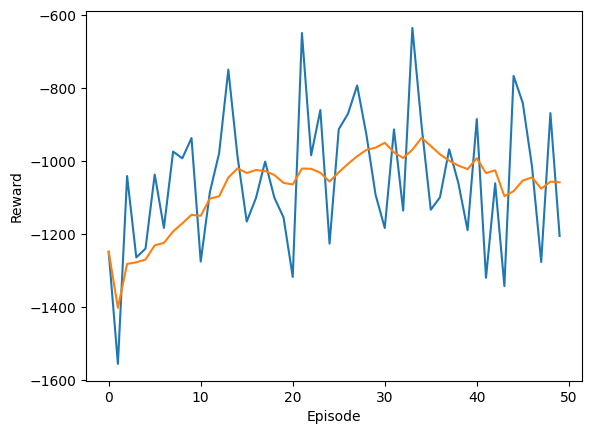

In [ ]:
import sys
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

env = NormalizedEnv(gym.make("Pendulum-v1"))

agent = DDPGagent(env,hidden_size=256, actor_learning_rate=1e-4, critic_learning_rate=1e-3, gamma=0.99, tau=1e-2, max_memory_size=50000)
noise = OUNoise(env.action_space, mu=0.0, theta=0.13, max_sigma=1, min_sigma=0.3, decay_period=100000)
batch_size = 128
rewards = []
avg_rewards = []

for episode in range(50):
    state = env.reset()
    noise.reset()
    episode_reward = 0

    for step in range(500):
        action = agent.get_action(state)
        #Add noise to action

        action = noise.get_action(action)
        new_state, reward, done, _ = env.step(action)
        agent.memory.push(state, action, reward, new_state, done)

        if len(agent.memory) > batch_size:
            agent.update(batch_size)

        state = new_state
        episode_reward += reward

        if done:
            sys.stdout.write("episode: {}, reward: {}, average _reward: {} \n".format(episode, np.round(episode_reward, decimals=2), np.mean(rewards[-10:])))
            break

    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))

plt.plot(rewards)
plt.plot(avg_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

Changing the  parameter theta with variance for the Noise creation


episode: 0, reward: -1102.1, average _reward: nan 
episode: 1, reward: -1222.63, average _reward: -1102.1009042549258 
episode: 2, reward: -1600.09, average _reward: -1162.3634537078028 
episode: 3, reward: -1600.79, average _reward: -1308.2717288910228 
episode: 4, reward: -1295.6, average _reward: -1381.4017274840626 
episode: 5, reward: -1057.71, average _reward: -1364.2415403362543 
episode: 6, reward: -884.6, average _reward: -1313.1524646373666 
episode: 7, reward: -881.61, average _reward: -1251.9303062594333 
episode: 8, reward: -708.4, average _reward: -1205.6407334122898 
episode: 9, reward: -625.43, average _reward: -1150.3919645646047 
episode: 10, reward: -981.04, average _reward: -1097.8957684790835 
episode: 11, reward: -863.23, average _reward: -1085.789190582873 
episode: 12, reward: -502.14, average _reward: -1049.8499940124477 
episode: 13, reward: -766.24, average _reward: -940.0551155795077 
episode: 14, reward: -506.3, average _reward: -856.5999331231358 
episode:

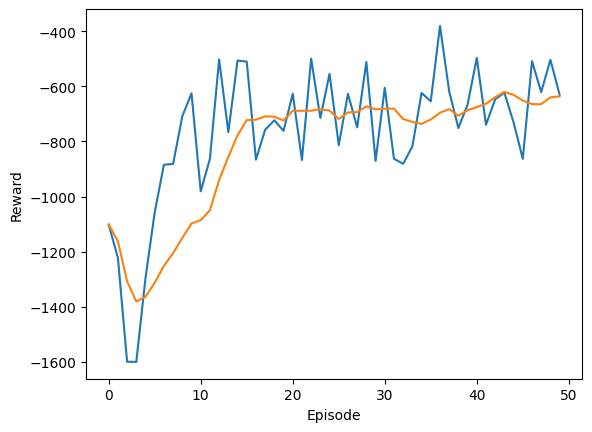

In [ ]:
import sys
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

env = NormalizedEnv(gym.make("Pendulum-v1"))

agent = DDPGagent(env)
noise = OUNoise(env.action_space, mu=0, theta=0.5, max_sigma=1, min_sigma=0.3, decay_period=100000)
batch_size = 128
rewards = []
avg_rewards = []

for episode in range(50):
    state = env.reset()
    noise.reset()
    episode_reward = 0

    for step in range(500):
        action = agent.get_action(state)
        #Add noise to action

        action = noise.get_action(action)
        new_state, reward, done, _ = env.step(action)
        agent.memory.push(state, action, reward, new_state, done)

        if len(agent.memory) > batch_size:
            agent.update(batch_size)

        state = new_state
        episode_reward += reward

        if done:
            sys.stdout.write("episode: {}, reward: {}, average _reward: {} \n".format(episode, np.round(episode_reward, decimals=2), np.mean(rewards[-10:])))
            break

    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))

plt.plot(rewards)
plt.plot(avg_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

Changing the value of gamma parameter

episode: 0, reward: -1326.57, average _reward: nan 
episode: 1, reward: -1606.44, average _reward: -1326.5675559324136 
episode: 2, reward: -1496.85, average _reward: -1466.5029492643155 
episode: 3, reward: -1266.63, average _reward: -1476.6174415205196 
episode: 4, reward: -1218.75, average _reward: -1424.121507369665 
episode: 5, reward: -1094.21, average _reward: -1383.0478693527248 
episode: 6, reward: -917.87, average _reward: -1334.909006081399 
episode: 7, reward: -1175.4, average _reward: -1275.3323674257547 
episode: 8, reward: -933.77, average _reward: -1262.8404648475266 
episode: 9, reward: -914.3, average _reward: -1226.277184134869 
episode: 10, reward: -761.48, average _reward: -1195.0796483074791 
episode: 11, reward: -785.52, average _reward: -1138.571285336907 
episode: 12, reward: -759.05, average _reward: -1056.4796198121799 
episode: 13, reward: -505.45, average _reward: -982.6994986104086 
episode: 14, reward: -495.98, average _reward: -906.5814720147512 
episode

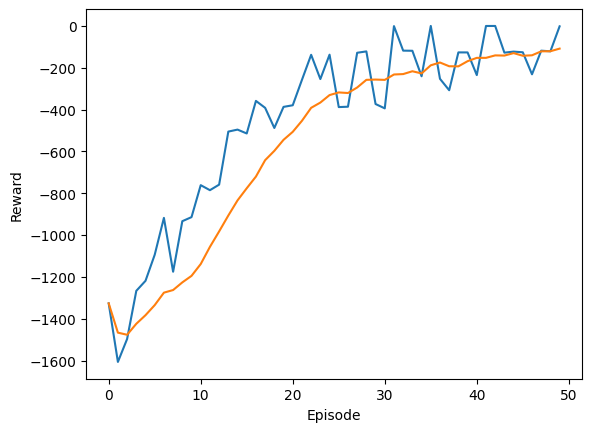

In [ ]:
import sys
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

env = NormalizedEnv(gym.make("Pendulum-v1"))

agent = DDPGagent(env,hidden_size=256, actor_learning_rate=1e-4, critic_learning_rate=1e-3, gamma=0.99999, tau=1e-2, max_memory_size=50000)
noise = OUNoise(env.action_space, mu=0, theta=0.13, max_sigma=0.1, min_sigma=0.1, decay_period=100000)
batch_size = 128
rewards = []
avg_rewards = []

for episode in range(50):
    state = env.reset()
    noise.reset()
    episode_reward = 0

    for step in range(500):
        action = agent.get_action(state)
        #Add noise to action

        action = noise.get_action(action)
        new_state, reward, done, _ = env.step(action)
        agent.memory.push(state, action, reward, new_state, done)

        if len(agent.memory) > batch_size:
            agent.update(batch_size)

        state = new_state
        episode_reward += reward

        if done:
            sys.stdout.write("episode: {}, reward: {}, average _reward: {} \n".format(episode, np.round(episode_reward, decimals=2), np.mean(rewards[-10:])))
            break

    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))

plt.plot(rewards)
plt.plot(avg_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

#### Your Inference

**OBSERVATIONS: **

* If we increase the variance of the noise, the agent doesn't really converge in 50 episodes as the rewards do not increase at the same rate.

* But if we also increase theta to 0.5, then the agent converges with average rewards of -647.

* On decreasing the value of gamma to 0.5, the agent is not able to converge in 50 episodes and average rewards remain around -1268

* On increasing gamma close to 1 (0.9999) and decreasing the variance of the noise, the rewards increase significantly to -121.

**INFERENCES: **

**Increasing the Variance of the Noise:**

When the variance of the noise is increased, it adds more exploration to the agent's actions. This can result in slower convergence or even prevent convergence altogether.

**Adjusting the Ornstein-Uhlenbeck Noise Parameters (Theta):**

Higher values of theta increase the tendency of the noise to return to the mean quickly. This can stabilize the exploration process and help the agent converge more effectively.

**Modifying the Discount Factor (Gamma):**

Decreasing the discount factor gamma reduces the weight given to future rewards in the agent's learning process.If the environment requires considering long-term consequences, a low gamma may hinder convergence as the agent fails to adequately account for future rewards.

**Adjusting Gamma Close to 1:**

Increasing gamma close to 1 means the agent assigns higher importance to future rewards. This can be beneficial in environments where long-term planning is crucial. However, excessively high gamma values may lead to issues such as delayed rewards or difficulty in learning due to the problem of vanishing gradients.

**Impact of Noise Variance and Gamma on Convergence:**

Decreasing the variance of the noise and increasing gamma close to 1 resulted in significant improvement in rewards, indicating that a balance between exploration and exploitation is essential for convergence. Lower noise variance reduces excessive exploration, while a higher gamma encourages the agent to consider future rewards, enabling it to learn a more optimal policy over time.